<a href="https://colab.research.google.com/github/christianbv/AgeNet/blob/main/Notebooks/2_Train_model_single_and_multiple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

In [ ]:
!pip install dlib
!pip install face_recognition

     |████████████████████████████████| 100.2MB 57kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=46a794e566a2b0c73988084e31fa92f551f862b0698066eda445e099dda36ab2
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [ ]:
#@markdown <b>Run me to import underscore module</b><br/>   {display-mode: "form"}
#@markdown <small>Method signatures:</small><br/> 
#@markdown <small><small>&nbsp; &nbsp; &nbsp; __(source_path, target_path, copy=True, auth_on_upload=True)</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _set_gh_token(token)</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _from_gh(user_name, repo_name, release_name) &nbsp; &nbsp; &nbsp; <b>Returns:</B> dictionary of arrays { 'array_name' : np.ndarray }</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _to_gh(user_name, repo_name, release_name, split_size=600, **arr_kwargs)</small></small><br/>


!pip install -q githubrelease
import numpy as np
import os, glob, re, time
import github_release

compressed_dirs = set()


def _compress(source_path, target_path, target_dir=None):
    if target_dir:
        !mkdir -p {target_dir}
    if target_path.endswith('.tar.gz'):
        !tar -czf {target_path} -C {source_path} .
    elif target_path.endswith('.tar'):
        !tar -cf {target_path} -C {source_path} .
    elif target_path.endswith('.zip'):
        !(cd {source_path} && zip -q -r {target_path} .)


def _extract(source_path, target_path):
    !mkdir -p {target_path}
    if source_path.endswith('.tar.gz'):
        !tar -xzf {source_path} -C {target_path}
    elif source_path.endswith('.tar'):
        !tar -xf {source_path} -C {target_path}
    elif source_path.endswith('.zip'):
        !unzip -qq {source_path} -d {target_path}


def __(source_path, target_path, copy=True, auth_on_upload=True):
    """
    Use cases:
        Movement:
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Compression (e.g. from dir to .tar.gz):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Extraction (e.g. from .zip to dir):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Extraction & compression (e.g. from .zip to .tar.gz):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
    """
    COMPRESSION_FORMATS = ('zip', 'tar', 'tar.gz')
    TEMP_DIR = "/tmp_"
    LOG_TEMPLATE = "{}    from    {}    to    {}"

    # Source
    if source_path.endswith("/"):
        source_path = source_path[:-1]
    source_dir, _, source_name = source_path.rpartition('/')
    source_isgcs = source_path.startswith("gs://")
    source_islocal = not source_isgcs
    if source_islocal:
        source_path = os.path.abspath(source_path)
    source_isprefix, source_isfile, source_ext = source_name.partition('.')
    source_isdir = not source_isfile
    source_iscompression = source_ext in COMPRESSION_FORMATS

    # Target
    target_dir, _, target_name = target_path.rpartition('/')
    target_isgcs = target_path.startswith("gs://")
    target_islocal = not target_isgcs
    target_prefix, target_isfile, target_ext = target_name.partition('.')
    target_isdir = not target_isfile
    target_iscompression = target_ext in COMPRESSION_FORMATS

    # Flags
    MOVE_ONLY = source_ext == target_ext
    GCS_ONLY = source_isgcs and target_isgcs
    RENAME = source_isprefix != target_prefix
    COMPRESSION = source_isdir and target_iscompression
    EXTRACTION = source_iscompression and target_isdir
    EXTRACTION_COMPRESSION = source_iscompression and target_iscompression and source_ext != target_ext

    # Add forward slash if file is at root level
    source_dir = "/" if not source_dir else source_dir
    target_dir = "/" if not target_dir else target_dir

    # Authenticate if writing to GCS
    if target_isgcs and auth_on_upload:
        from google.colab import auth
        auth.authenticate_user()

    # Assert that subdirectories exist if target is local
    if target_islocal:
        !mkdir -p {target_dir}

    # Movement commands
    if MOVE_ONLY:
        # GCS -> GCS
        if source_isgcs and target_isgcs:
            action = "COPYING" if copy else "MOVING"
            print(LOG_TEMPLATE.format(f"{action} (1/1)", source_path, target_path))
            if copy:
                !gsutil -m -q cp -r {source_path} {target_path}
            else:
                !gsutil -m -q mv {source_path} {target_path}
        
        # LOCAL -> LOCAL
        elif source_islocal and target_islocal:
            action = "COPYING" if copy else "MOVING"
            print(LOG_TEMPLATE.format(f"{action} (1/1)", source_path, target_path))
            if copy:
                !cp -r {source_path} {target_path}
            else:
                !mv {source_path} {target_path}
        
        # GCS -> LOCAL
        elif source_isgcs and target_islocal:
            if source_isdir:
                print(LOG_TEMPLATE.format("DOWNLOADING DIR (1/1)", source_path, target_dir))
                !gsutil -m -q cp -r {source_path} {target_dir}
                if RENAME:
                    print(LOG_TEMPLATE.format("\tRENAMING DIR", source_isprefix, target_prefix))
                    !mv {target_dir}/{source_isprefix} {target_dir}/{target_prefix}
            else:
                print(LOG_TEMPLATE.format("DOWNLOADING FILE (1/1)", source_path, target_path))
                !gsutil -m -q cp {source_path} {target_path}
        
        # LOCAL -> GCS
        if source_islocal and target_isgcs:
            if source_isdir:
                print(LOG_TEMPLATE.format("UPLOADING DIR (1/1)", source_path, target_path))
                !gsutil -m -q cp -r {source_path} {target_path}
            else:
                print(LOG_TEMPLATE.format("UPLOADING FILE (1/1)", source_path, target_path))
                !gsutil -m -q cp {source_path} {target_path}
        return


    # Create directory for intermediate storage if required
    if source_isgcs or target_isgcs or EXTRACTION_COMPRESSION:
        !mkdir -p {TEMP_DIR}
    

    # For remaining operations, download GCS source to temp and treat as local
    if source_isgcs:
        if source_isdir:
            print(LOG_TEMPLATE.format("\tDOWNLOADING DIR", source_path, TEMP_DIR))
            !gsutil -m -q cp -r {source_path} {TEMP_DIR}
        else:
            print(LOG_TEMPLATE.format("\tDOWNLOADING FILE", source_path, f"{TEMP_DIR}/{source_name}"))
            !gsutil -m -q cp {source_path} {TEMP_DIR}/{source_name}
        source_path = f"{TEMP_DIR}/{source_name}"
        source_dir = TEMP_DIR

    # Compression
    if COMPRESSION:
        if target_islocal:
            print(LOG_TEMPLATE.format("COMPRESSING (1/1)", source_path, target_path))
            _compress(source_path, target_path, target_dir=target_dir)
        else:
            print(LOG_TEMPLATE.format("COMPRESSING (1/2)", source_path, f"{TEMP_DIR}/{target_name}"))
            _compress(source_path, f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING FILE (2/2)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp {TEMP_DIR}/{target_name} {target_path}

    # Extraction
    elif EXTRACTION:
        if target_islocal:
            print(LOG_TEMPLATE.format("EXTRACTING (1/1)", source_path, target_path))
            _extract(source_path, target_path)
        else:
            print(LOG_TEMPLATE.format("EXTRACTING (1/2)", source_path, f"{TEMP_DIR}/{target_name}"))
            _extract(source_path, f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING DIR (2/2)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp -r {TEMP_DIR}/{target_name} {target_path}

    # Extraction & compression
    elif EXTRACTION_COMPRESSION:
        if target_islocal:
            print(LOG_TEMPLATE.format("EXTRACTING (1/2)", source_path, f"{TEMP_DIR}/{target_prefix}"))
            _extract(source_path, f"{TEMP_DIR}/{target_prefix}")
            print(LOG_TEMPLATE.format("COMPRESSING (2/2)", f"{TEMP_DIR}/{target_prefix}", target_path))
            _compress(f"{TEMP_DIR}/{target_prefix}", target_path, target_dir=target_dir)
        else:
            print(LOG_TEMPLATE.format("EXTRACTING (1/3)", source_path, f"{TEMP_DIR}/{target_prefix}"))
            _extract(source_path, f"{TEMP_DIR}/{target_prefix}")
            print(LOG_TEMPLATE.format("COMPRESSING (2/3)", f"{TEMP_DIR}/{target_prefix}", f"{TEMP_DIR}/{target_name}"))
            _compress(f"{TEMP_DIR}/{target_prefix}", f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING FILE (3/3)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp {TEMP_DIR}/{target_name} {target_path}
    
    # Cleanup intermediate storage
    !rm -rf {TEMP_DIR}


def _set_gh_token(token):
    os.environ["GITHUB_TOKEN"] = token


def _export_array(array, release_name, prefix="", splits=3):
    dir_path = f"/tmp_/{release_name}"
    !mkdir -p {dir_path}
    n_digits = len(str(splits - 1))
    subarrays = np.array_split(array, splits)
    for i, subarray in enumerate(subarrays):
        filename = f"{prefix}__{str(i).zfill(n_digits)}.npy"
        np.save(f"{dir_path}/{filename}", subarray)


def _concat_arrays(paths):
    return np.concatenate([np.load(path, allow_pickle=True) for path in sorted(paths)])


def _to_gh(user_name, repo_name, release_name, split_size=600, **arr_kwargs):
    # Assert that GitHub Auth token is set
    if "GITHUB_TOKEN" not in os.environ:
        print("GitHub authentication token is not set.")
        print("Set token using the '_set_gh_token(token_string)' method.")
        print("Minimal required auth scope is 'repo/public_repo' for public repositories.")
        print("URL: https://github.com/settings/tokens/new")
        return

    # Split arrays
    for prefix, array in arr_kwargs.items():
        splits = int((array.nbytes/1_000_000) // split_size) + 1
        _export_array(array, release_name, prefix=prefix, splits=splits)

    # Upload arrays
    github_release.gh_release_create(
        f"{user_name}/{repo_name}", 
        release_name, 
        publish=True, 
        name=release_name, 
        asset_pattern=f"/tmp_/{release_name}/*"
    )
    !rm -rf /tmp_/*


def _from_gh(user_name, repo_name, release_name):
    # Download release to temporary directory
    print("Downloading dataset in parallell ... ", end='\t')
    t0 = time.perf_counter()
    assets = github_release.get_assets(f"{user_name}/{repo_name}", tag_name=release_name)
    download_urls = [asset['browser_download_url'] for asset in assets]
    urls_str = " ".join(download_urls)
    !echo {urls_str} | xargs -n 1 -P 8 wget -q -P /tmp_/{release_name}_dl/
    t1 = time.perf_counter()
    print(f"done! ({t1 - t0:.3f} seconds)")

    # Load data into numpy arrays
    paths = glob.glob(f"/tmp_/{release_name}_dl/*.npy")
    groups = {}
    for path in paths:
        match = re.match(r".*/(.*)__[0-9]*\.npy", path)
        if match:
            prefix = match.group(1)
            groups[prefix] = groups.get(prefix, []) + [path]
    arrays_dict = {name: _concat_arrays(paths) for name, paths in groups.items()}
    !rm -rf /tmp_/*
    return arrays_dict
    

def _log_to_gh(user, repo, tag, log_dir="/tmp/logs"):
    # Create temporary directory for compressed logs
    !mkdir -p /tmp/compressed_logs
    
    # Compress all directories in log dir
    for dirname in os.listdir(log_dir):
        # Skip files
        if "." in dirname or dirname in compressed_dirs:
            continue

        # Compress
        __(f"{log_dir}/{dirname}", f"/tmp/compressed_logs/{dirname}.tar.gz")
        compressed_dirs.add(dirname)

    # Upload compressed logs to GitHub
    github_release.gh_asset_upload(f"{user}/{repo}", tag, f"/tmp/compressed_logs/*.tar.gz")

    # Cleanup compressed logs
    !rm -rf /tmp/compressed_logs/*

In [ ]:
from google.colab import auth


from google.colab import drive

import os
from os import walk 

from os import listdir
from os.path import isfile, join
from IPython.display import display
from PIL import Image, ImageDraw
import numpy as np
import glob
import shutil
import shutil
#import face_recognition
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.get_logger().setLevel('ERROR')
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
from tensorboard.plugins.hparams import api as hp

In [ ]:
seed = 42
img_height, img_width = 256, 256
batch_size = 32
validation_size = 0
num_classes = 10
label_mode = 'categorical' # 'int', or 'categorical'. Make loss optimizer match up with the label mode (SpareLossEntropy for int )
LOG_DIR = "/content/logs"

# 1. Download and aggregate all the proeprocessed images 

In [ ]:
data_folder = "/content/images_by_age"# The path where the data is located end 

__("gs://ntnu-ml-bucket/IMDB/IMDB_by_age.zip", "/content/images_by_age")
__("gs://ntnu-ml-bucket/Appa/appa_by_age_256_FIXED.zip","/content/images_by_age" )
__("gs://ntnu-ml-bucket/Utk/utk_by_age_256_FIXED.zip" ,"/content/images_by_age")

	DOWNLOADING FILE    from    gs://ntnu-ml-bucket/IMDB/IMDB_by_age.zip    to    /tmp_/IMDB_by_age.zip
EXTRACTING (1/1)    from    /tmp_/IMDB_by_age.zip    to    /content/images_by_age
	DOWNLOADING FILE    from    gs://ntnu-ml-bucket/Appa/appa_by_age_256_FIXED.zip    to    /tmp_/appa_by_age_256_FIXED.zip
EXTRACTING (1/1)    from    /tmp_/appa_by_age_256_FIXED.zip    to    /content/images_by_age
	DOWNLOADING FILE    from    gs://ntnu-ml-bucket/Utk/utk_by_age_256_FIXED.zip    to    /tmp_/utk_by_age_256_FIXED.zip
EXTRACTING (1/1)    from    /tmp_/utk_by_age_256_FIXED.zip    to    /content/images_by_age


# 2. Methods to:

1.   Create the train and validation dataset
2.   Build the model
3.   Train the model

In [ ]:
# Fetch classes

def build_dataset(batch_size, dataset_paths):
  class_names_1 = sorted([label for label in os.listdir(dataset_paths[0])],key = lambda x: int(x.split("-")[0]))
  for i in range(len(dataset_paths)):

      temp_train_ds  = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_paths[i], 
        labels='inferred', 
        label_mode=label_mode, 
        class_names=class_names_1,
        color_mode='rgb',  # 3-channel CNNs (ev. grayscale for å redusere kompleksitet)
        batch_size=batch_size, 
        image_size=(img_height, img_width), 
        shuffle=True, 
        seed=this_seed,
        validation_split=validation_size, 
        subset="training", 
        interpolation='bilinear', 
        follow_links=False
     )
      
      temp_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_paths[i],
        labels = 'inferred',
        label_mode = label_mode,
        class_names=class_names_1,
        validation_split=validation_size,
        subset="validation",
        seed=this_seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
      )
      if i == 0:
        train_ds = temp_train_ds
        val_ds = temp_val_ds
        continue
      
      train_ds = train_ds.concatenate(temp_train_ds)
      val_ds = val_ds.concatenate(temp_val_ds)

  return train_ds, val_ds

  
train_ds, val_ds = build_dataset(128,[data_folder])
# Setter opp slik at ikke I/O står i veien for trening
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(300).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


optimizers = {
    'adam': tf.keras.optimizers.Adam,
    'rmsprop': tf.keras.optimizers.RMSprop,
    'sgd': tf.keras.optimizers.SGD
}

def build_model(hparams):
    model = tf.keras.Sequential()

    # Create augmentation model
    augmentation = keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
        layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width)),
    ], name="DataAugmentation")
    model.add(augmentation)
    # Convolutional units
    conv_filters = hparams['conv_filters']
    for i in range(hparams['conv_layers']):
        if(i == 0):
            stride_len = int(np.ceil(hparams['conv_kernel_size']/2))
            model.add(tf.keras.layers.Conv2D(
                filters=conv_filters,
                strides = (stride_len,stride_len),
                kernel_size=hparams['conv_kernel_size'], 
                activation='relu',
                padding='same'
            ))
        else:
            model.add(tf.keras.layers.Conv2D(
                filters=conv_filters,
                kernel_size= 3, 
                activation='relu',
                padding='same'
            ))
        #model.add(tf.keras.layers.BatchNormalization())
        if( i < 4 and hparams['conv_kernel_size'] == 3):
          model.add(tf.keras.layers.MaxPool2D(strides=hparams['pool_stride']))
        elif(i<3 and hparams['conv_kernel_size'] == 5):
          model.add(tf.keras.layers.MaxPool2D(strides=hparams['pool_stride']))
        elif(i<2 and hparams['conv_kernel_size'] == 7 ):
          model.add(tf.keras.layers.MaxPool2D(strides=hparams['pool_stride']))
        model.add(tf.keras.layers.Dropout(hparams['dropout'])) 
   
        conv_filters *= 2
  
    model.add(tf.keras.layers.Flatten())
    # Dense unit
    dense_units = hparams['dense_units']
    for _ in range(hparams['dense_layers']):
        model.add(tf.keras.layers.Dense(dense_units, activation='relu'))
       
        dense_units /= 2
    model.add(layers.Dense(num_classes))
    return model

def train_model(hparams, metrics, log_dir, **fit_kwargs):
    print(hparams)
    # Create callbacks and prepare logging
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True, )
    base_line = EarlyStopping(monitor='val_accuracy', patience=6, baseline = 0.25)
    dir_name = f"cnn_{datetime.now():%Y%m%d_%H%M%S}"
    filename = f"{log_dir}/{dir_name}"
    hparams["__timestamp__"] = int(f"{datetime.now():%Y%m%d%H%M%S}")
    tensorboard = TensorBoard(filename, write_graph=False, histogram_freq=0, write_images=False)
    hp_board = hp.KerasCallback(filename, hparams, trial_id=dir_name)
    callbacks = [tensorboard, hp_board, early_stopping, base_line]

    # Build model and run
    model = build_model(hparams)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
    
    model.compile(
        optimizer=optimizers[hparams['optimizer']](learning_rate=hparams['learning_rate']), 
        loss=loss, 
        metrics=['accuracy']
    )
    print(model.summary())
    history = model.fit(callbacks=callbacks, **fit_kwargs)
    return model, history, dir_name

# Evaluation metrics
metrics = tf.keras.metrics.CategoricalAccuracy()

Found 66358 files belonging to 10 classes.
Using 53087 files for training.
Found 66358 files belonging to 10 classes.
Using 13271 files for validation.


# 3. Train a single model

In [ ]:
# Set hyperparameter
hparams = {
    'conv_layers': 5,
    'conv_filters': 64,
    'conv_kernel_size': 3,
    'pool_stride': 2,

    'dense_layers': 2,
    'dense_units': 256,
    'dropout': 0.186,

    'batch_size': 32,
    'optimizer': 'adam',
    'learning_rate': 0.0003,
}

# Build datasets
train_ds, val_ds = build_dataset(hparams['batch_size'],[data_folder])


fit_kwargs = {
    "x": train_ds,
    "validation_data": val_ds,
    "epochs": 15,
    "verbose": 1
}
model, history, model_name = train_model(hparams, metrics, log_dir=LOG_DIR, **fit_kwargs)

Found 66358 files belonging to 10 classes.
Using 53087 files for training.
Found 66358 files belonging to 10 classes.
Using 13271 files for validation.
{'conv_layers': 5, 'conv_filters': 64, 'conv_kernel_size': 3, 'pool_stride': 2, 'dense_layers': 2, 'dense_units': 256, 'dropout': 0.186, 'batch_size': 32, 'optimizer': 'adam', 'learning_rate': 0.0003}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DataAugmentation (Sequential (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________

# 4. Train multiple models with uniform hyperparamet search

In [ ]:
# Set ranges for the hyperparameters
hparams_refs = {
    'conv_layers': hp.HParam('conv_layers', hp.IntInterval(1,4)),
    'conv_filters': hp.HParam('conv_filters', hp.Discrete([16, 32])),
    'conv_kernel_size': hp.HParam('conv_kernel_size', hp.Discrete([3,4,5])),
    'pool_stride': hp.HParam('pool_stride', hp.Discrete([2])),
    
    'dense_layers': hp.HParam('dense_layers', hp.IntInterval(1, 2)),
    'dense_units': hp.HParam('dense_units', hp.Discrete([128, 64, 32])),
    'dropout': hp.HParam('dropout', hp.RealInterval(0.05, 0.2)),

    'batch_size': hp.HParam('batch_size', hp.Discrete([32, 64,128])),
    'optimizer': hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop', 'sgd'])),
    'learning_rate': hp.HParam('learning_rate', hp.Discrete([ 10e-3, 10**-3.5, 10e-4, 10**-4.5, 10e-5, 10**-5.5])),
}

In [ ]:
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True, )
    base_line = EarlyStopping(monitor='val_accuracy', patience=6, baseline = 0.25)
    callbacks =[early_stopping, base_line]

In [ ]:
# Random serach with parameter lock
# Set hyperparameters (Comment out to lock parameter)
hparams_locked = {
    #'conv_layers': 4,
    #'conv_filters': 16,
    #'conv_kernel_size': 3,
    #'pool_stride': 2,

    #'dense_layers': 2,
     #'dense_units': 128,
    #'dropout': 0.1,

     #'batch_size': 128,
     'optimizer': 'adam', # 
    # 'learning_rate': 0.01,
}

NUM_ITERATIONS = 200
for i in range(NUM_ITERATIONS):
    hparams = {k: v.domain.sample_uniform() for k, v in hparams_refs.items() if k not in hparams_locked}
    hparams.update(hparams_locked)

    # Build datasets
    train_ds,val_ds = build_dataset(hparams['batch_size'],[data_folder_utk,data_folder_appa])
    #train_dataset, val_dataset, test_dataset = datasets

    fit_kwargs = {
        "x": train_ds,
        "validation_data": val_ds,
        "epochs": 20,
        "verbose": 1
    }
    model, history, model_name = train_model(hparams, metrics, log_dir=LOG_DIR, **fit_kwargs)

In [ ]:
history = model.fit(callbacks=callbacks, **fit_kwargs)
h.append(history)

Epoch 1/15
1659/1659 [==============================] - 259s 156ms/step - loss: 1.0805 - accuracy: 0.5457 - val_loss: 1.1386 - val_accuracy: 0.5194
Epoch 2/15
1659/1659 [==============================] - 253s 153ms/step - loss: 1.0698 - accuracy: 0.5487 - val_loss: 1.1242 - val_accuracy: 0.5266
Epoch 3/15
1659/1659 [==============================] - 256s 154ms/step - loss: 1.0584 - accuracy: 0.5524 - val_loss: 1.1642 - val_accuracy: 0.5147
Epoch 4/15
1659/1659 [==============================] - 257s 155ms/step - loss: 1.0500 - accuracy: 0.5583 - val_loss: 1.1505 - val_accuracy: 0.5131
Epoch 5/15
1659/1659 [==============================] - 255s 154ms/step - loss: 1.0436 - accuracy: 0.5617 - val_loss: 1.1522 - val_accuracy: 0.5181
Epoch 6/15
1659/1659 [==============================] - 253s 153ms/step - loss: 1.0339 - accuracy: 0.5684 - val_loss: 1.1331 - val_accuracy: 0.5241
Epoch 7/15
1659/1659 [==============================] - 254s 153ms/step - loss: 1.0210 - accuracy: 0.5720 - val_

# 5. Test the model

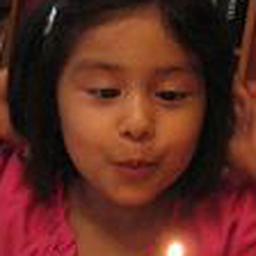

/content/images_by_age/3-6


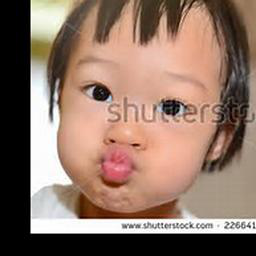

/content/images_by_age/3-6


/content/images_by_age/3-6


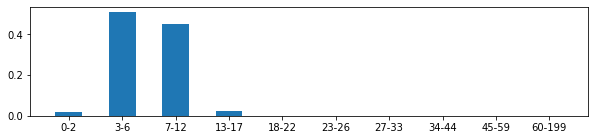

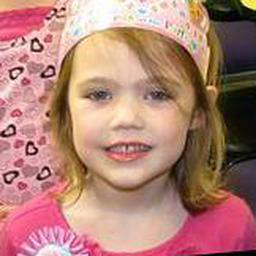

/content/images_by_age/3-6


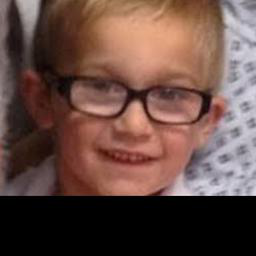

/content/images_by_age/3-6


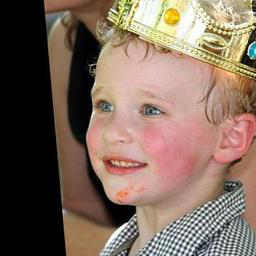

/content/images_by_age/3-6


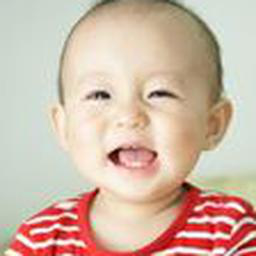

/content/images_by_age/0-2


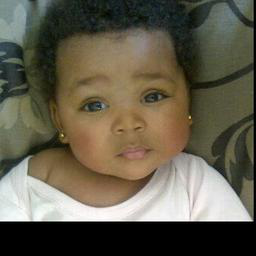

/content/images_by_age/0-2


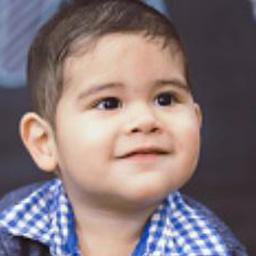

/content/images_by_age/0-2


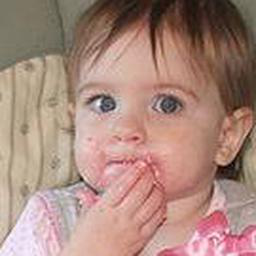

/content/images_by_age/0-2


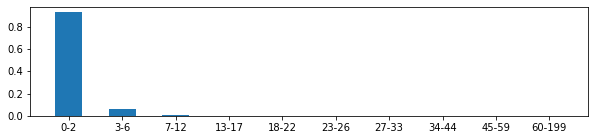

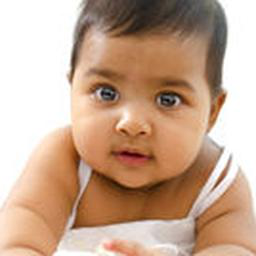

/content/images_by_age/0-2


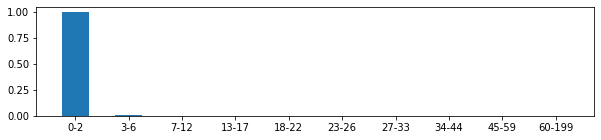

/content/images_by_age/0-2


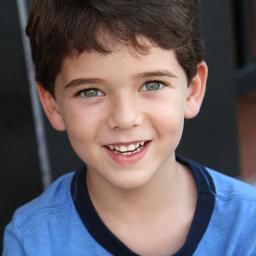

/content/images_by_age/7-12


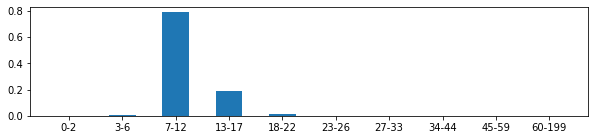

/content/images_by_age/7-12


/content/images_by_age/7-12


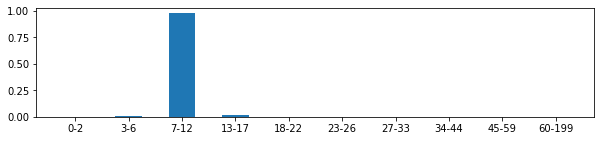

/content/images_by_age/7-12


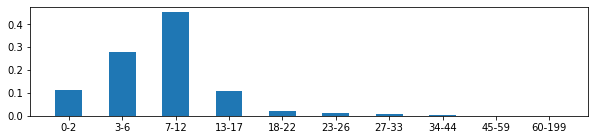

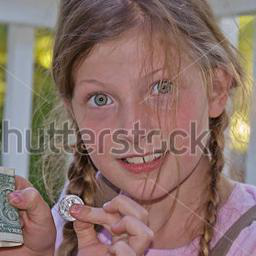

/content/images_by_age/7-12


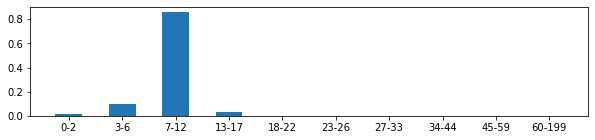

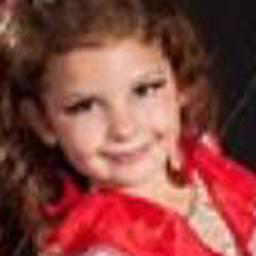

/content/images_by_age/7-12


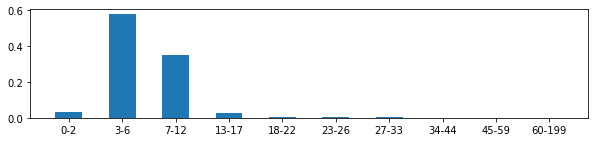

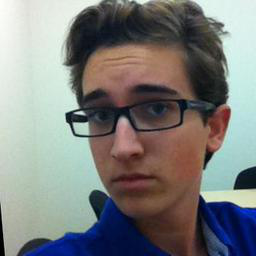

/content/images_by_age/13-17


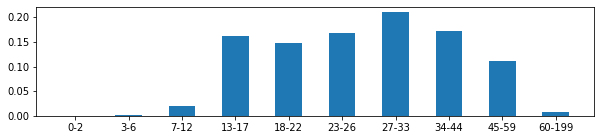

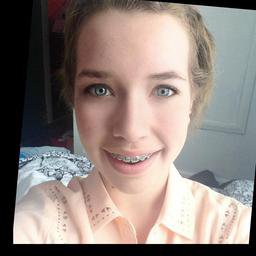

/content/images_by_age/13-17


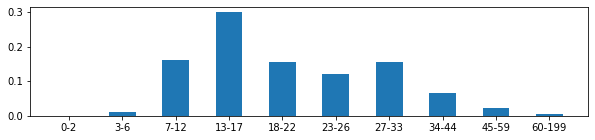

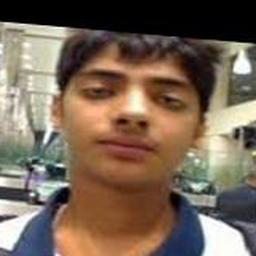

/content/images_by_age/13-17


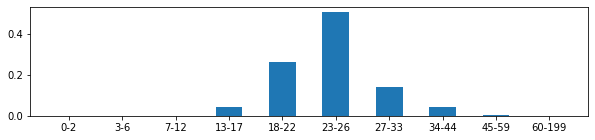

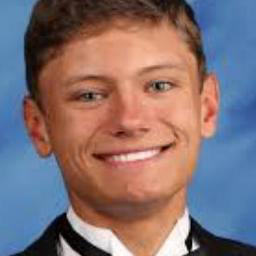

/content/images_by_age/13-17


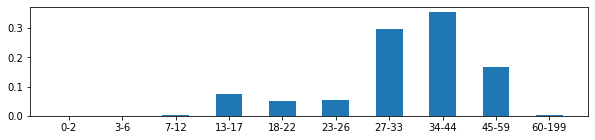

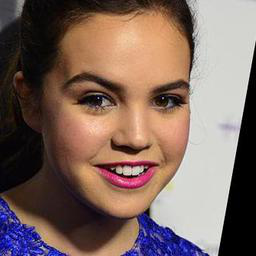

/content/images_by_age/13-17


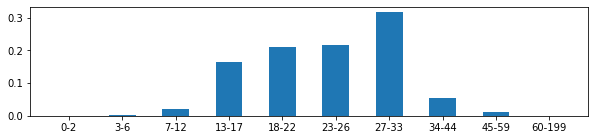

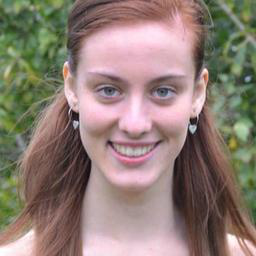

/content/images_by_age/13-17


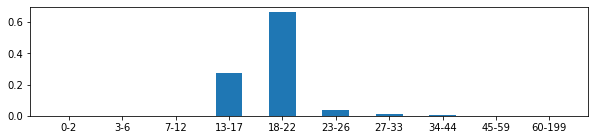

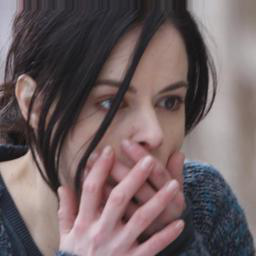

/content/images_by_age/27-33


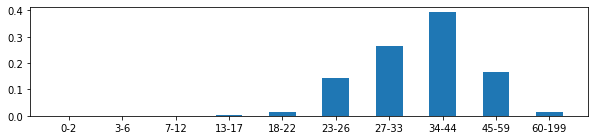

/content/images_by_age/27-33


/content/images_by_age/27-33


/content/images_by_age/27-33


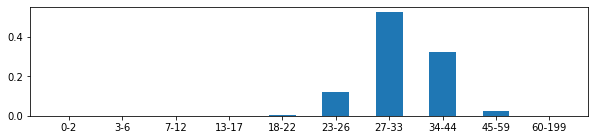

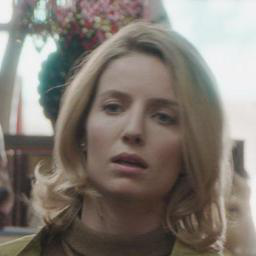

/content/images_by_age/27-33


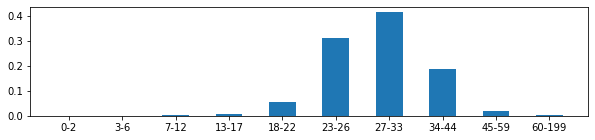

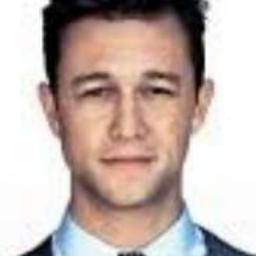

/content/images_by_age/27-33


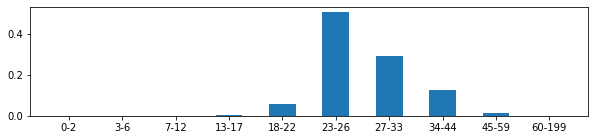

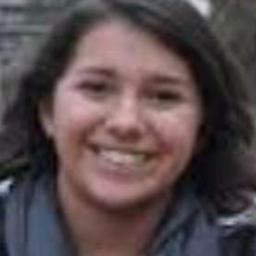

/content/images_by_age/23-26


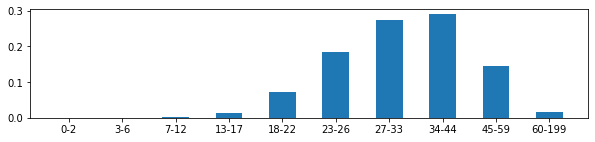

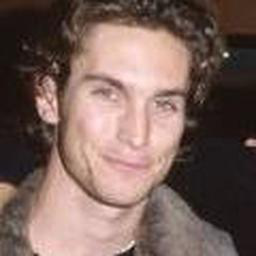

/content/images_by_age/23-26


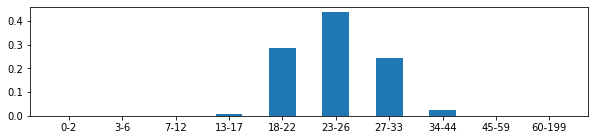

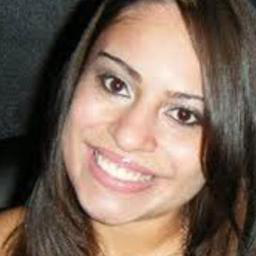

/content/images_by_age/23-26


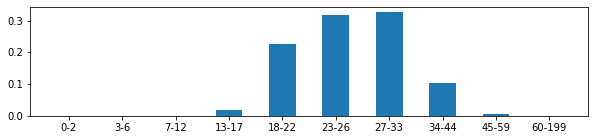

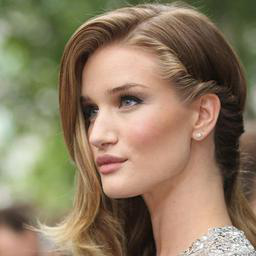

/content/images_by_age/23-26


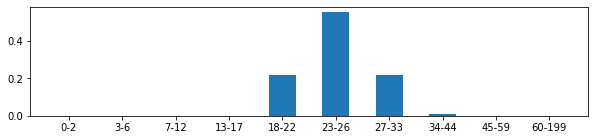

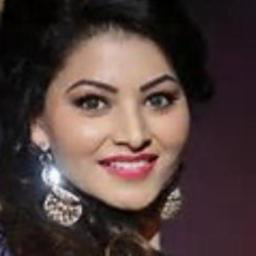

/content/images_by_age/23-26


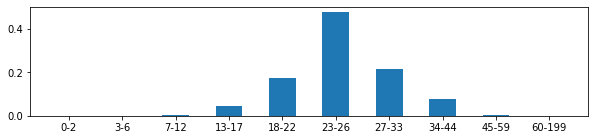

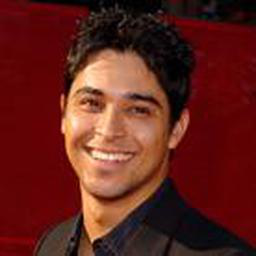

/content/images_by_age/23-26


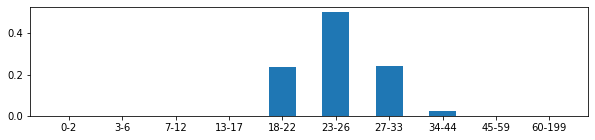

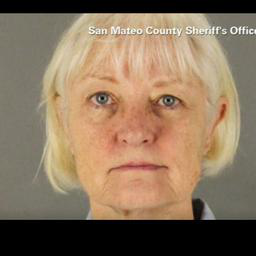

/content/images_by_age/60-199


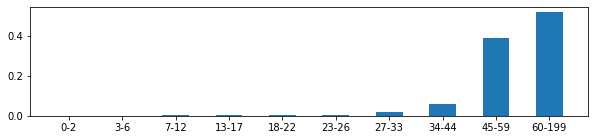

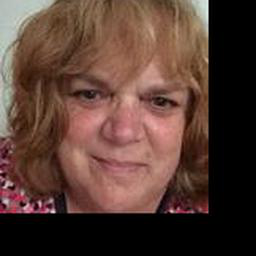

/content/images_by_age/60-199


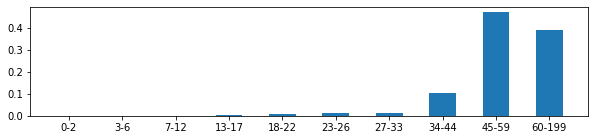

/content/images_by_age/60-199


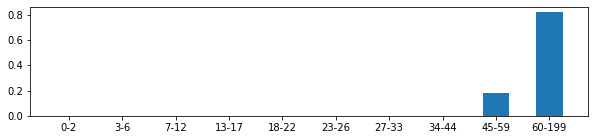

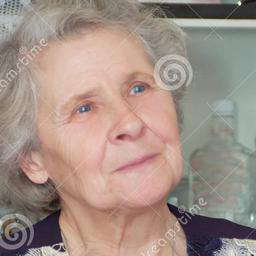

/content/images_by_age/60-199


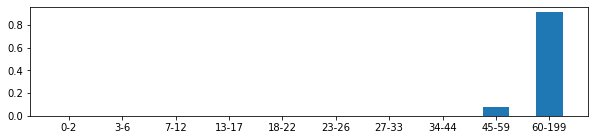

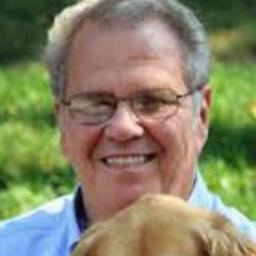

/content/images_by_age/60-199


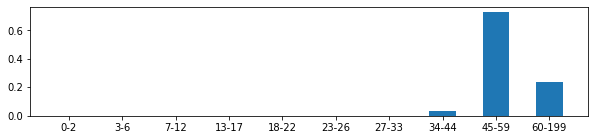

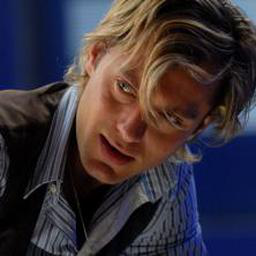

/content/images_by_age/60-199


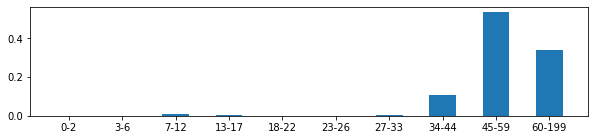

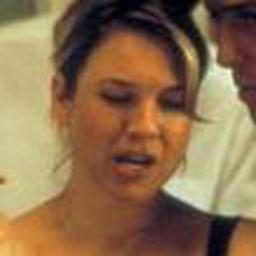

/content/images_by_age/34-44


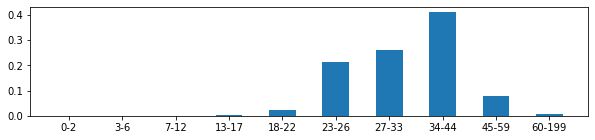

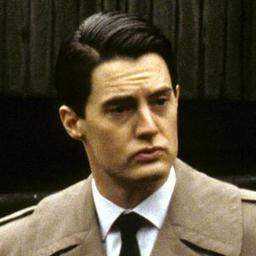

/content/images_by_age/34-44


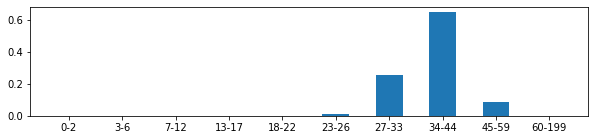

/content/images_by_age/34-44


/content/images_by_age/34-44


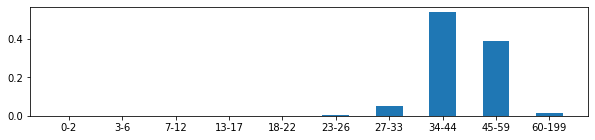

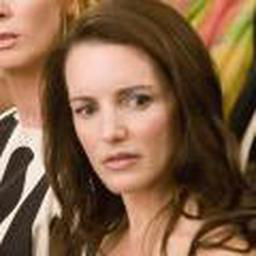

/content/images_by_age/34-44


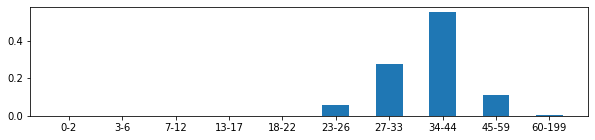

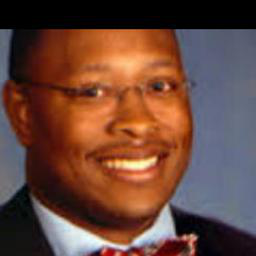

/content/images_by_age/34-44


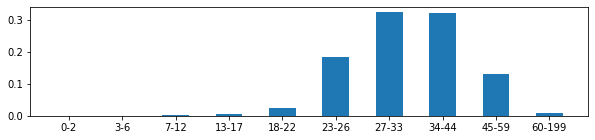

/content/images_by_age/18-22


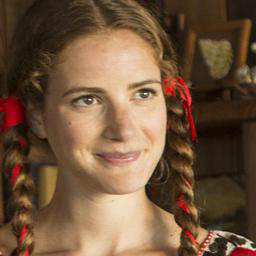

/content/images_by_age/18-22


/content/images_by_age/18-22


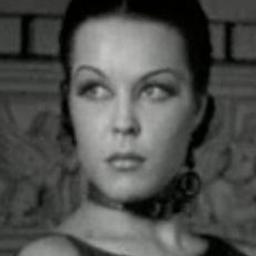

/content/images_by_age/18-22


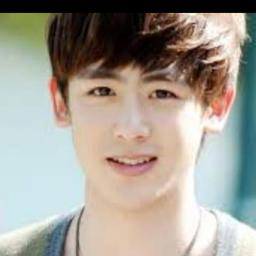

/content/images_by_age/18-22


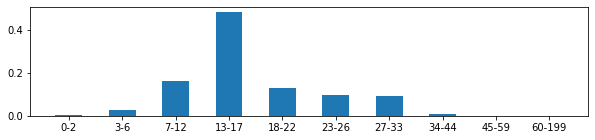

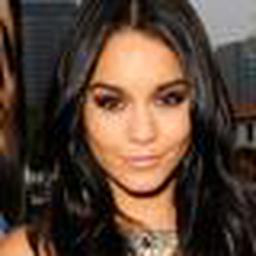

/content/images_by_age/18-22


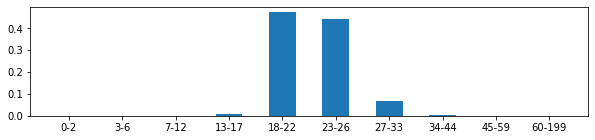

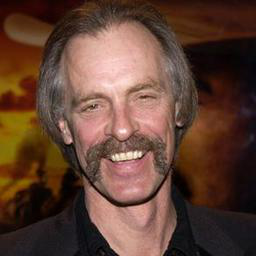

/content/images_by_age/45-59


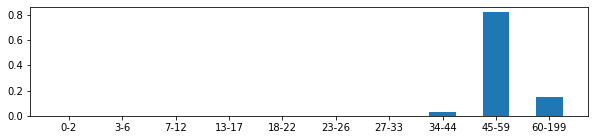

/content/images_by_age/45-59


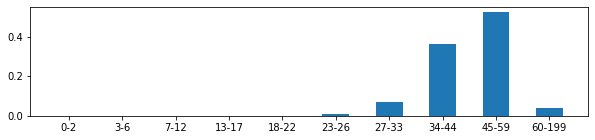

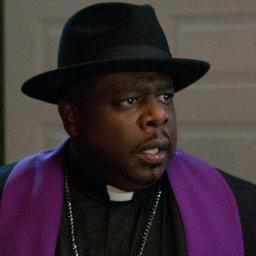

/content/images_by_age/45-59


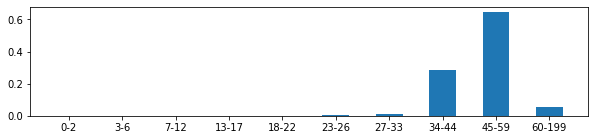

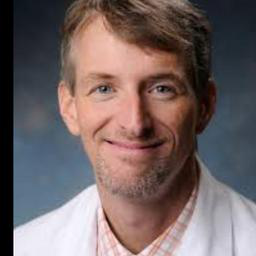

/content/images_by_age/45-59


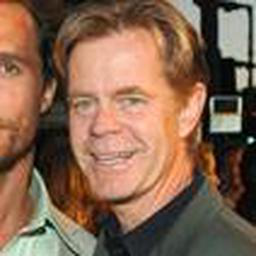

/content/images_by_age/45-59


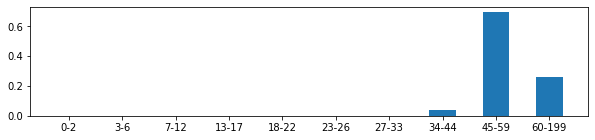

/content/images_by_age/45-59


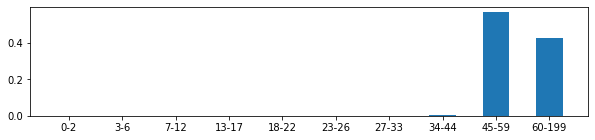

In [ ]:

from IPython.display import display

for dir in os.listdir("/content/images_by_age"):
  count = 0 
  for (dirpath, dirnames, filenames) in walk ("/content/images_by_age/" + dir):
      for f in filenames:
        if not f.endswith(".jpg"):
          continue
        img = Image.open(dirpath +"/" + f)
        display(img)
        print(dirpath)
        #img = preprocess_image(dirpath +"/" + f)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        class_labels = ['0-2', '3-6', '7-12', '13-17', '18-22', '23-26', '27-33', '34-44', '45-59', '60-199']

        class_labels, score = zip(*sorted(zip(class_labels,score), key = lambda x: int(x[0].split("-")[0])))
      
        plt.figure(figsize=(10,2))
        plt.bar(class_labels,score,width=0.5)
        plt.show()
        count += 1
        if(count > 5):
          break
      if(count > 5 ):
        break


In [ ]:
## Save the model
!mkdir -p saved_models
model.save("/content/saved_models/model_2")
__("/content/saved_models/model_2", "gs://ntnu-ml-bucket/models/model_3_11_11.zip", auth_on_upload=False)